# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

# Frame The Problem

1. **Define the objective in business terms.**
- The objective is to predict if a flight will be delayed or cancelled seven days in advance whether that be due to weather, mechanical issues, or other reasons. This will allow airlines and airports to better plan for the future and roll out delay or cancellation alerts to passengers more efficiently.
2. **How will your solution be used?**
- Our solution will be used to predict if a flight will be delayed or cancelled seven days in advance. This will allow airlines and airports to better plan for the future and roll out delay or cancellation alerts to passengers more efficiently.
3. **What are the current solutions/workarounds (if any)?**
- Currently, airlines and airports do not have a way to predict if a flight will be delayed or cancelled seven days in advance. They can only predict if a flight will be delayed or cancelled a few hours in advance.
4. **How should you frame this problem (supervised/unsupervised, online/offline, ...)?**
- This problem should be framed as a supervised learning problem. We will use historical data to predict if a flight will be delayed or cancelled seven days in advance. We will use a batch learning system to train the model as the system will be updated quarterly.
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
- Performance should be measured using the precision score. As the client stated they would like to accurately predict if a flight will be delayed or cancelled seven days in advance as to not inconvenience or frustrate passengers. The precision score is aligned with the business objective as it measures the number of actual positive cases that were correctly predicted as positive. To mitigate the risk of false positives, the precision score will be used as it aligns with the business objective and the client's needs.
6. **What would be the minimum performance needed to reach the business objective?**
- As per the client the minimum peroformance needed to reach the business objective is 25%. As they currently do not have a way to predict if a flight will be delayed or cancelled seven days in advance, any improvement on the current system would be beneficial.
7. **What are comparable problems? Can you reuse experience or tools?**
- A comparable problem I have worked with was in the AWS machine learning challenge lab where the mock client wanted to create a feature to let customers know if the flight will be delayed because of weather when they book a flight to or from the busiest airports for domestic travel in the US.
- There are tools and experience that can be reused that I have used in past homework assignments as well as the methods used in the AWS machine learning challenge lab to analyze the data.
8. **Is human expertise available?**
- No, human expertise is not available as the client is knowledgeable about the problem but does not thoroughly know the data being provided. But, my professor is knowledgeable in this area and can provide guidance and help if needed.
9. **How would you solve the problem manually?**
- To solve the problem manually, I would look at the historical data and see if there are any patterns or trends that can be used to predict if a flight will be delayed or cancelled seven days in advance. Finding as many patterns or trends as possible would be beneficial to predict if a flight will be delayed or cancelled as there could be multiple reasons why a flight would be delayed or cancelled. Although, it must be noted that real-time issues such as mechanical issues or staffing issus would be impossible to predict in advance. Although, a general trend could be found to imply a potential delay or cancellation due to these issues.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**

- bureau of transportation statistics
- carrier issues 
- extreme weather
- airport wind issues
- security or tsa
- late arrival (delay only)
* holidays
* weather
* don't consider diverted flight data
- no international fights
- size of airlines
- small airlines important
- make sure air crafts of an N to start the planes id
- seasonal and holiday travel

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Get the Data

In [9]:
# if parquet file exists
if os.path.exists('combined_air_travel_data.parquet'):
    print('Parquet file already exists.')
else:
    # Define the directory containing the CSV files
    directory = "BTS_csv_files"
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    csv_files.sort()  # Ensure they are in order

    df_list = []

    # Read and process each CSV file
    for file in csv_files:
        df = pd.read_csv(os.path.join(directory, file))
        
        # Ensure the date column is in datetime format
        if 'FlightDate' in df.columns:
            df['FlightDate'] = pd.to_datetime(df['FlightDate'])
        
        df_list.append(df)

    # Combine all DataFrames and sort by date
    combined_df = pd.concat(df_list, ignore_index=True)

    # Sort by FlightDate
    combined_df = combined_df.sort_values(by="FlightDate")

    # Save as a Parquet file
    combined_df.to_parquet("combined_air_travel_data.parquet", engine="pyarrow", index=False)

    print("Parquet file created successfully, sorted by FlightDate.")


Parquet file already exists.


In [10]:
def combine_and_save_plane_and_flight():    
    # ONLY RUN THIS FUNCTION ONCE

    # Load your BTS flight data from a Parquet file
    data = pd.read_parquet('combined_air_travel_data.parquet')  # Replace with your actual Parquet file path
    data = data.drop(columns=['DivAirportLandings','DivReachedDest','DivActualElapsedTime','DivArrDelay','DivDistance','Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 'Div2Airport', 'Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 'Div2TotalGTime', 'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum', 'Div3Airport', 'Div3AirportID', 'Div3AirportSeqID', 'Div3WheelsOn', 'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff', 'Div3TailNum', 'Div4Airport', 'Div4AirportID', 'Div4AirportSeqID', 'Div4WheelsOn', 'Div4TotalGTime', 'Div4LongestGTime', 'Div4WheelsOff', 'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum'])

    # Load aircraft data
    aircraft_data = pd.read_csv('aircrafts.csv')

    # Merge flight data with aircraft data (keeping all flights)
    merged_data = pd.merge(data, aircraft_data, how='left', left_on='Tail_Number', right_on='reg')

    # Load holiday data
    holiday_data = pd.read_csv('holidays.csv')

    # Ensure the date column is in datetime format
    holiday_data['date'] = pd.to_datetime(holiday_data['date'])

    # Merge holiday data (keeping all flights)
    merged_data = pd.merge(merged_data, holiday_data, how='left', left_on='FlightDate', right_on='date')

    merged_data.to_parquet("combined_air_travel_data.parquet", engine="pyarrow", index=False)

# RUN ME ONCE
# combine_and_save_plane_and_flight()

In [3]:
# Load weather data
weather_data = pd.read_parquet('weather.parquet')
# Load merge data
merged_data = pd.read_parquet('combined_air_travel_data.parquet')



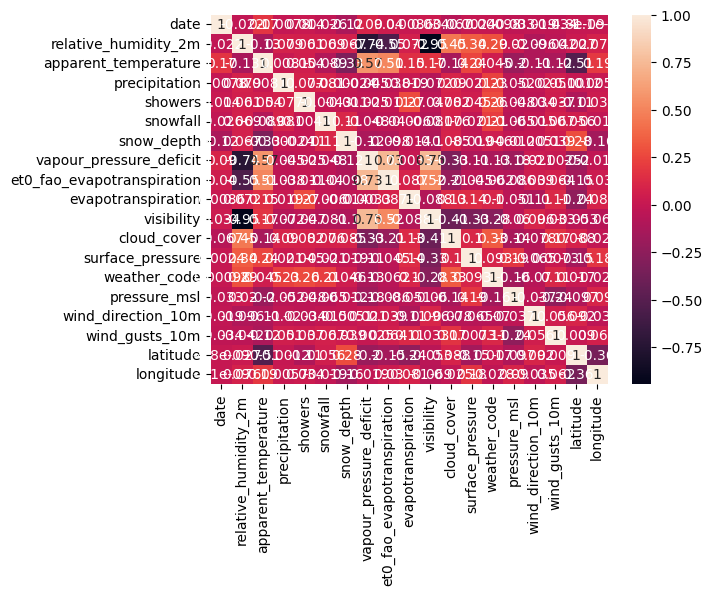

In [64]:
# corralation matrix
weather_data_corr = weather_data.drop(columns=['rain', 'temperature_2m', 'precipitation_probability', 'dew_point_2m', 'soil_temperature_0cm', 'soil_moisture_0_to_1cm', 'IATA', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_80m', 'wind_speed_120m', 'wind_speed_180m', 'temperature_80m', 'temperature_120m', 'temperature_180m', 'wind_direction_80m', 'wind_direction_120m', 'wind_direction_180m', 'wind_speed_10m'])
corr = weather_data_corr[weather_data_corr.columns].corr()
sns.heatmap(corr, annot=True)
plt.show()

- precipitation and rain are the same thing so we should drop one
- apparent_temperature and temperature_2m are 99% correlated
- dew_point_2m and apparent_temperature are 88% correlated knowing about physics that is because there is a non-linear correlation to pressure and temperature
- apparent_temperature and soil_temperature_0cm are 95% correlated and soil temperature seems odd to account for
- soil_moisture_0_to_1cm correlates with a lot of different features might be not good for predicting
- 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high' and almost the same as cloud_cover
- 'wind_speed_10m', 'wind_speed_80m', 'wind_speed_120m', 'wind_speed_180m' seem to be a gradient based on the height lets keep the bottom
- wind_speeds_10m and wind_gust_10m are nearly the same
- all the temps are very correlate so we don't need them all

In [23]:
weather_data['precipitation_probability'].value_counts()

precipitation_probability
0.0     301032
1.0      36958
2.0      12968
3.0       7843
4.0       5592
         ...  
94.0       174
97.0       171
85.0       169
98.0       166
88.0       161
Name: count, Length: 101, dtype: int64

- precipitation_probability is mostly not there and that is not because they marked 0% as nan as I suspect originally it looks like it just was not marked; we should likely drop that dat its not likely to be helpful.

In [21]:
corr['showers']['precipitation_probability']

nan

In [ ]:
merged_data.drop(
    columns=['CRSDepTime','DepTime','DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 
             'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 
             'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 
             'Flights', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 
             'TotalAddGTime', 'LongestAddGTime', 'Duplicate', 'Unnamed: 119', 'Originally_Scheduled_Code_Share_Airline',
             'DOT_ID_Originally_Scheduled_Code_Share_Airline', 'IATA_Code_Originally_Scheduled_Code_Share_Airline', 
             'Flight_Num_Originally_Scheduled_Code_Share_Airline'])

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
0,2023,1,1,1,7,2023-01-01,NK,NK,20416,NK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,1,1,1,7,2023-01-01,AA,AA_CODESHARE,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14825702,2024,4,12,31,2,2024-12-31,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14825703,2024,4,12,31,2,2024-12-31,AA,AA_CODESHARE,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14825704,2024,4,12,31,2,2024-12-31,NK,NK,20416,NK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14825705,2024,4,12,31,2,2024-12-31,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# weather_data['date'] = weather_data['date'].dt.tz_convert('UTC').dt.tz_localize(None)
weather_data['date'] = weather_data['date'].dt.tz_localize(None).astype('datetime64[ns]')

print(weather_data['date'].dtype)
print(merged_data['FlightDate'].dtype)

datetime64[ns]
datetime64[ns]


In [17]:

# Merge weather data (keeping all flights)
# merged_data = pd.merge(merged_data, weather_data, how='left', left_on=['FlightDate','Origin'], right_on=['date','IATA'])

In [18]:
# merged_data.to_parquet("combined_air_travel_data.parquet", engine="pyarrow", index=False)

In [19]:
# Target features

# create new columns for different cancellation reasons A for carrier, B for weather, C for NAS, D for security
merged_data['CarrierCancellation'] = merged_data['CancellationCode'] == 'A'
merged_data['WeatherCancellation'] = merged_data['CancellationCode'] == 'B'
merged_data['NASCancellation'] = merged_data['CancellationCode'] == 'C'
merged_data['SecurityCancellation'] = merged_data['CancellationCode'] == 'D'

# if the cancellation code is missing, it is unknown
merged_data['unknownCancellation'] = merged_data['CancellationCode'].isnull()

# create new columns for the different delay reasons with minor, moderate, severe classifications
merged_data['CarrierDelayMinor'] = (merged_data['CarrierDelay'] >= 15) & (merged_data['CarrierDelay'] <= 16)
merged_data['CarrierDelayModerate'] = (merged_data['CarrierDelay'] > 16) & (merged_data['CarrierDelay'] < 180)
merged_data['CarrierDelaySevere'] = merged_data['CarrierDelay'] >= 180

merged_data['WeatherDelayMinor'] = (merged_data['WeatherDelay'] >= 15) & (merged_data['WeatherDelay'] <= 16)
merged_data['WeatherDelayModerate'] = (merged_data['WeatherDelay'] > 16) & (merged_data['WeatherDelay'] < 180)
merged_data['WeatherDelaySevere'] = merged_data['WeatherDelay'] >= 180

merged_data['NASDelayMinor'] = (merged_data['NASDelay'] >= 15) & (merged_data['NASDelay'] <= 16)
merged_data['NASDelayModerate'] = (merged_data['NASDelay'] > 16) & (merged_data['NASDelay'] < 180)
merged_data['NASDelaySevere'] = merged_data['NASDelay'] >= 180

merged_data['SecurityDelayMinor'] = (merged_data['SecurityDelay'] >= 15) & (merged_data['SecurityDelay'] <= 16)
merged_data['SecurityDelayModerate'] = (merged_data['SecurityDelay'] > 16) & (merged_data['SecurityDelay'] < 180)
merged_data['SecurityDelaySevere'] = merged_data['SecurityDelay'] >= 180

merged_data['LateAircraftDelayMinor'] = (merged_data['LateAircraftDelay'] >= 15) & (merged_data['LateAircraftDelay'] <= 16)
merged_data['LateAircraftDelayModerate'] = (merged_data['LateAircraftDelay'] > 16) & (merged_data['LateAircraftDelay'] < 180)
merged_data['LateAircraftDelaySevere'] = merged_data['LateAircraftDelay'] >= 180

# create new column for on-time arrival
merged_data['OnTimeArrival'] = merged_data['ArrDelay'] < 15



In [20]:
#target columns
target_columns = ['CarrierCancellation', 'WeatherCancellation', 'NASCancellation', 'SecurityCancellation', 'unknownCancellation', 'CarrierDelayMinor', 'CarrierDelayModerate', 'CarrierDelaySevere', 'WeatherDelayMinor', 'WeatherDelayModerate', 'WeatherDelaySevere', 'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere', 'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere', 'LateAircraftDelayMinor', 'LateAircraftDelayModerate', 'LateAircraftDelaySevere', 'OnTimeArrival']

# delay columns
delay_cols = ['CarrierDelayMinor', 'CarrierDelayModerate', 'CarrierDelaySevere', 'WeatherDelayMinor', 'WeatherDelayModerate', 'WeatherDelaySevere', 'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere', 'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere', 'LateAircraftDelayMinor', 'LateAircraftDelayModerate', 'LateAircraftDelaySevere']

# cancel columns
cancellation_cols = ['CarrierCancellation', 'WeatherCancellation', 'NASCancellation', 'SecurityCancellation']

In [21]:
merged_data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,NASDelayMinor,NASDelayModerate,NASDelaySevere,SecurityDelayMinor,SecurityDelayModerate,SecurityDelaySevere,LateAircraftDelayMinor,LateAircraftDelayModerate,LateAircraftDelaySevere,OnTimeArrival
0,2023,1,1,1,7,2023-01-01,NK,NK,20416,NK,...,False,False,False,False,False,False,False,False,False,True
1,2023,1,1,1,7,2023-01-01,AA,AA_CODESHARE,19805,AA,...,False,False,False,False,False,False,False,False,False,True
2,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,False,False,False,False,False,False,False,False,False,False
3,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,False,False,False,False,False,False,False,False,False,True
4,2023,1,1,1,7,2023-01-01,UA,UA,19977,UA,...,False,False,False,False,False,False,False,False,False,True


In [22]:
merged_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825707 entries, 0 to 14825706
Columns: 141 entries, Year to OnTimeArrival
dtypes: bool(21), datetime64[ns](1), float64(73), int64(20), object(26)
memory usage: 13.5+ GB


In [23]:
"""
# Downloads lat, lng data for US cities
cities = pd.read_csv('uscities.csv') # https://simplemaps.com/data/us-cities
cities = cities[['city', 'state_id', 'lat', 'lng']]
cities = cities.drop(columns=['city', 'state_id'])
cities = cities.drop_duplicates()
cities.to_csv('lat_lng.csv', index=False)
"""

"\n# Downloads lat, lng data for US cities\ncities = pd.read_csv('uscities.csv') # https://simplemaps.com/data/us-cities\ncities = cities[['city', 'state_id', 'lat', 'lng']]\ncities = cities.drop(columns=['city', 'state_id'])\ncities = cities.drop_duplicates()\ncities.to_csv('lat_lng.csv', index=False)\n"

In [24]:
"""
# Downloads weather data by lat and lng

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
vars =["wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "temperature_2m", "relative_humidity_2m", 
       "dew_point_2m", "apparent_temperature", "precipitation_probability", "precipitation", "rain", "showers", "snowfall", 
       "snow_depth", "weather_code", "surface_pressure", "pressure_msl", "cloud_cover", "visibility"]
params = {
	"latitude": cities['lat'][:20],
	"longitude": cities['lng'][:20],
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": vars
}
responses = openmeteo.weather_api(url, params=params)
"""



'\n# Downloads weather data by lat and lng\n\nimport openmeteo_requests\nimport requests_cache\nimport pandas as pd\nfrom retry_requests import retry\n\n# Setup the Open-Meteo API client with cache and retry on error\ncache_session = requests_cache.CachedSession(\'.cache\', expire_after = 3600)\nretry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)\nopenmeteo = openmeteo_requests.Client(session = retry_session)\n\n# Make sure all required weather variables are listed here\n# The order of variables in hourly or daily is important to assign them correctly below\nurl = "https://archive-api.open-meteo.com/v1/archive"\nvars =["wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "temperature_2m", "relative_humidity_2m", \n       "dew_point_2m", "apparent_temperature", "precipitation_probability", "precipitation", "rain", "showers", "snowfall", \n       "snow_depth", "weather_code", "surface_pressure", "pressure_msl", "cloud_cover", "visibility"]\nparams = {\n\t"latitud

In [25]:
"""
# reformatting the weather data
weather_data = pd.DataFrame()
for response in responses:
    new_weather_data = pd.DataFrame(response.Hourly().Variables(0).ValuesAsNumpy())
    for i in range (1, len(vars)):
        new_weather_data[vars[i]] = response.Hourly().Variables(i).ValuesAsNumpy()
    new_weather_data['time'] = response.Hourly().Time()
    new_weather_data['latitude'] = response.Latitude()
    new_weather_data['longitude'] = response.Longitude()
    weather_data = pd.concat([weather_data, new_weather_data])
weather_data.head()
"""

"\n# reformatting the weather data\nweather_data = pd.DataFrame()\nfor response in responses:\n    new_weather_data = pd.DataFrame(response.Hourly().Variables(0).ValuesAsNumpy())\n    for i in range (1, len(vars)):\n        new_weather_data[vars[i]] = response.Hourly().Variables(i).ValuesAsNumpy()\n    new_weather_data['time'] = response.Hourly().Time()\n    new_weather_data['latitude'] = response.Latitude()\n    new_weather_data['longitude'] = response.Longitude()\n    weather_data = pd.concat([weather_data, new_weather_data])\nweather_data.head()\n"

In [26]:

full_train_data, test_data = train_test_split(merged_data, test_size=0.1, random_state=42)
# Sample the train data for faster processing
train_data = full_train_data.sample(frac=0.2, random_state=42)

In [27]:
train_data = train_data.drop(
    columns=['CRSDepTime','DepTime','DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 
             'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 
             'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 
             'Flights', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 
             'TotalAddGTime', 'LongestAddGTime', 'Duplicate', 'Unnamed: 119', 'Originally_Scheduled_Code_Share_Airline',
             'DOT_ID_Originally_Scheduled_Code_Share_Airline', 'IATA_Code_Originally_Scheduled_Code_Share_Airline', 
             'Flight_Num_Originally_Scheduled_Code_Share_Airline'])

In [28]:
train_data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,NASDelayMinor,NASDelayModerate,NASDelaySevere,SecurityDelayMinor,SecurityDelayModerate,SecurityDelaySevere,LateAircraftDelayMinor,LateAircraftDelayModerate,LateAircraftDelaySevere,OnTimeArrival
13974827,2024,4,11,20,3,2024-11-20,AA,AA,19805,AA,...,False,True,False,False,False,False,False,False,False,False
12979848,2024,4,10,3,4,2024-10-03,WN,WN,19393,WN,...,False,False,False,False,False,False,False,False,False,True
4946906,2023,3,9,6,3,2023-09-06,UA,UA_CODESHARE,19977,UA,...,False,False,False,False,False,False,False,False,False,False
2215742,2023,2,4,25,2,2023-04-25,AA,AA_CODESHARE,19805,AA,...,False,False,False,False,False,False,False,False,False,True
12684587,2024,3,9,19,4,2024-09-19,DL,DL,19790,DL,...,False,False,False,False,False,False,False,False,False,True


In [29]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056640 entries, 0 to 6056639
Data columns (total 39 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   temperature_2m              float64       
 2   relative_humidity_2m        float64       
 3   dew_point_2m                float64       
 4   precipitation_probability   float64       
 5   apparent_temperature        float64       
 6   precipitation               float64       
 7   rain                        float64       
 8   showers                     float64       
 9   snowfall                    float64       
 10  snow_depth                  float64       
 11  soil_temperature_0cm        float64       
 12  soil_moisture_0_to_1cm      float64       
 13  vapour_pressure_deficit     float64       
 14  et0_fao_evapotranspiration  float64       
 15  evapotranspiration          float64       
 16  visibility        

In [30]:
for i in target_columns:
    if train_data[i] == True:
        train_data['target'] = i
train_data['target'] = train_data['target']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
train_data.info()

In [ ]:
print("The #rows and #columns are ", train_data.shape[0] , " and ", train_data.shape[1])
print("The years in this dataset are: ", train_data.Year.unique())
print("The months covered in this dataset are: ", train_data.Month.unique())
print("The Origin airports covered are: ", list(train_data.Origin.unique()))
print("The Destination airports covered are: ", list(train_data.Dest.unique()))

The #rows and #columns are  2671928  and  123
The years in this dataset are:  [2024 2023]
The months covered in this dataset are:  [ 9 10  2  8 12  6  4 11  5  1  7  3]
The Origin airports covered are:  ['GRB', 'ORD', 'LIH', 'BOI', 'AUS', 'DFW', 'ATL', 'OAK', 'ILM', 'PHL', 'CLE', 'DEN', 'PNS', 'CLT', 'RSW', 'STL', 'PHX', 'SLC', 'LAS', 'COS', 'FAT', 'GEG', 'LIT', 'DCA', 'JAX', 'IND', 'FLL', 'RIC', 'HRL', 'PDX', 'LGA', 'IAH', 'BOS', 'SRQ', 'OMA', 'DAL', 'BUR', 'MKE', 'BWI', 'HNL', 'DTW', 'RDU', 'BNA', 'TYS', 'SMF', 'LAX', 'ORF', 'RAP', 'IAD', 'MLB', 'PVD', 'SFO', 'MSY', 'BZN', 'TWF', 'MDW', 'MSP', 'SEA', 'DLH', 'MIA', 'SAT', 'SAN', 'JFK', 'SJU', 'HPN', 'MCO', 'CMH', 'TPA', 'PIT', 'OGG', 'ICT', 'CID', 'ECP', 'OKC', 'PIA', 'ELP', 'SYR', 'MHT', 'ROC', 'CAK', 'DSM', 'ABQ', 'ONT', 'EWR', 'LGB', 'CHS', 'ALB', 'MOT', 'SNA', 'HSV', 'SBP', 'BTV', 'FAR', 'XNA', 'PBI', 'MCI', 'MLI', 'BGR', 'PWM', 'ANC', 'CRP', 'VPS', 'TUS', 'DAY', 'SDF', 'ATW', 'LBB', 'ACY', 'SJC', 'CMI', 'GRR', 'CHA', 'AMA', 'CVG'

In [ ]:
train_data.describe()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,...,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude
count,2.671928e+06,2.671928e+06,2.671928e+06,2.671928e+06,2.671928e+06,2671928,2.671928e+06,2.671928e+06,2.671928e+06,2.671928e+06,...,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06,2.558201e+06
mean,2.023509e+03,2.526955e+00,6.579212e+00,1.575762e+01,3.978795e+00,2024-01-05 23:18:03.661536256,1.982671e+04,2.554257e+03,1.996540e+04,2.554156e+03,...,1.867326e+02,1.865607e+02,1.862168e+02,1.876777e+02,1.989498e+01,1.637348e+01,1.632811e+01,1.631343e+01,3.672756e+01,-9.466491e+01
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2023-01-01 00:00:00,1.939300e+04,1.000000e+00,1.939300e+04,1.000000e+00,...,6.585307e-01,4.212772e-01,3.845308e-01,3.148083e-01,3.600000e-01,-3.638050e+01,-3.578050e+01,-3.538050e+01,-1.433100e+01,-1.766428e+02
25%,2.023000e+03,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,2023-07-08 00:00:00,1.979000e+04,1.155000e+03,1.979000e+04,1.155000e+03,...,1.084350e+02,1.084350e+02,1.084350e+02,1.106955e+02,1.044000e+01,1.049250e+01,1.044450e+01,1.039600e+01,3.336990e+01,-1.085430e+02
50%,2.024000e+03,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,2024-01-07 00:00:00,1.980500e+04,2.236000e+03,1.993000e+04,2.236000e+03,...,1.850424e+02,1.867098e+02,1.892725e+02,1.915048e+02,1.728000e+01,1.755850e+01,1.756550e+01,1.774550e+01,3.736260e+01,-8.790480e+01
75%,2.024000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,2024-07-08 00:00:00,1.997700e+04,3.781000e+03,2.036800e+04,3.780000e+03,...,2.700000e+02,2.700000e+02,2.649576e+02,2.656618e+02,2.664000e+01,2.296100e+01,2.291100e+01,2.298050e+01,4.077720e+01,-8.094310e+01
max,2.024000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2024-12-31 00:00:00,2.043600e+04,9.697000e+03,2.050000e+04,9.697000e+03,...,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,1.299600e+02,4.386450e+01,4.376450e+01,4.324900e+01,7.128540e+01,1.457290e+02
std,4.999135e-01,1.107510e+00,3.406698e+00,8.792389e+00,2.008398e+00,NaN,2.825184e+02,1.711284e+03,3.749008e+02,1.711170e+03,...,9.921351e+01,9.871487e+01,9.787957e+01,9.747088e+01,1.249494e+01,9.120451e+00,9.116365e+00,9.149630e+00,6.016122e+00,1.856670e+01


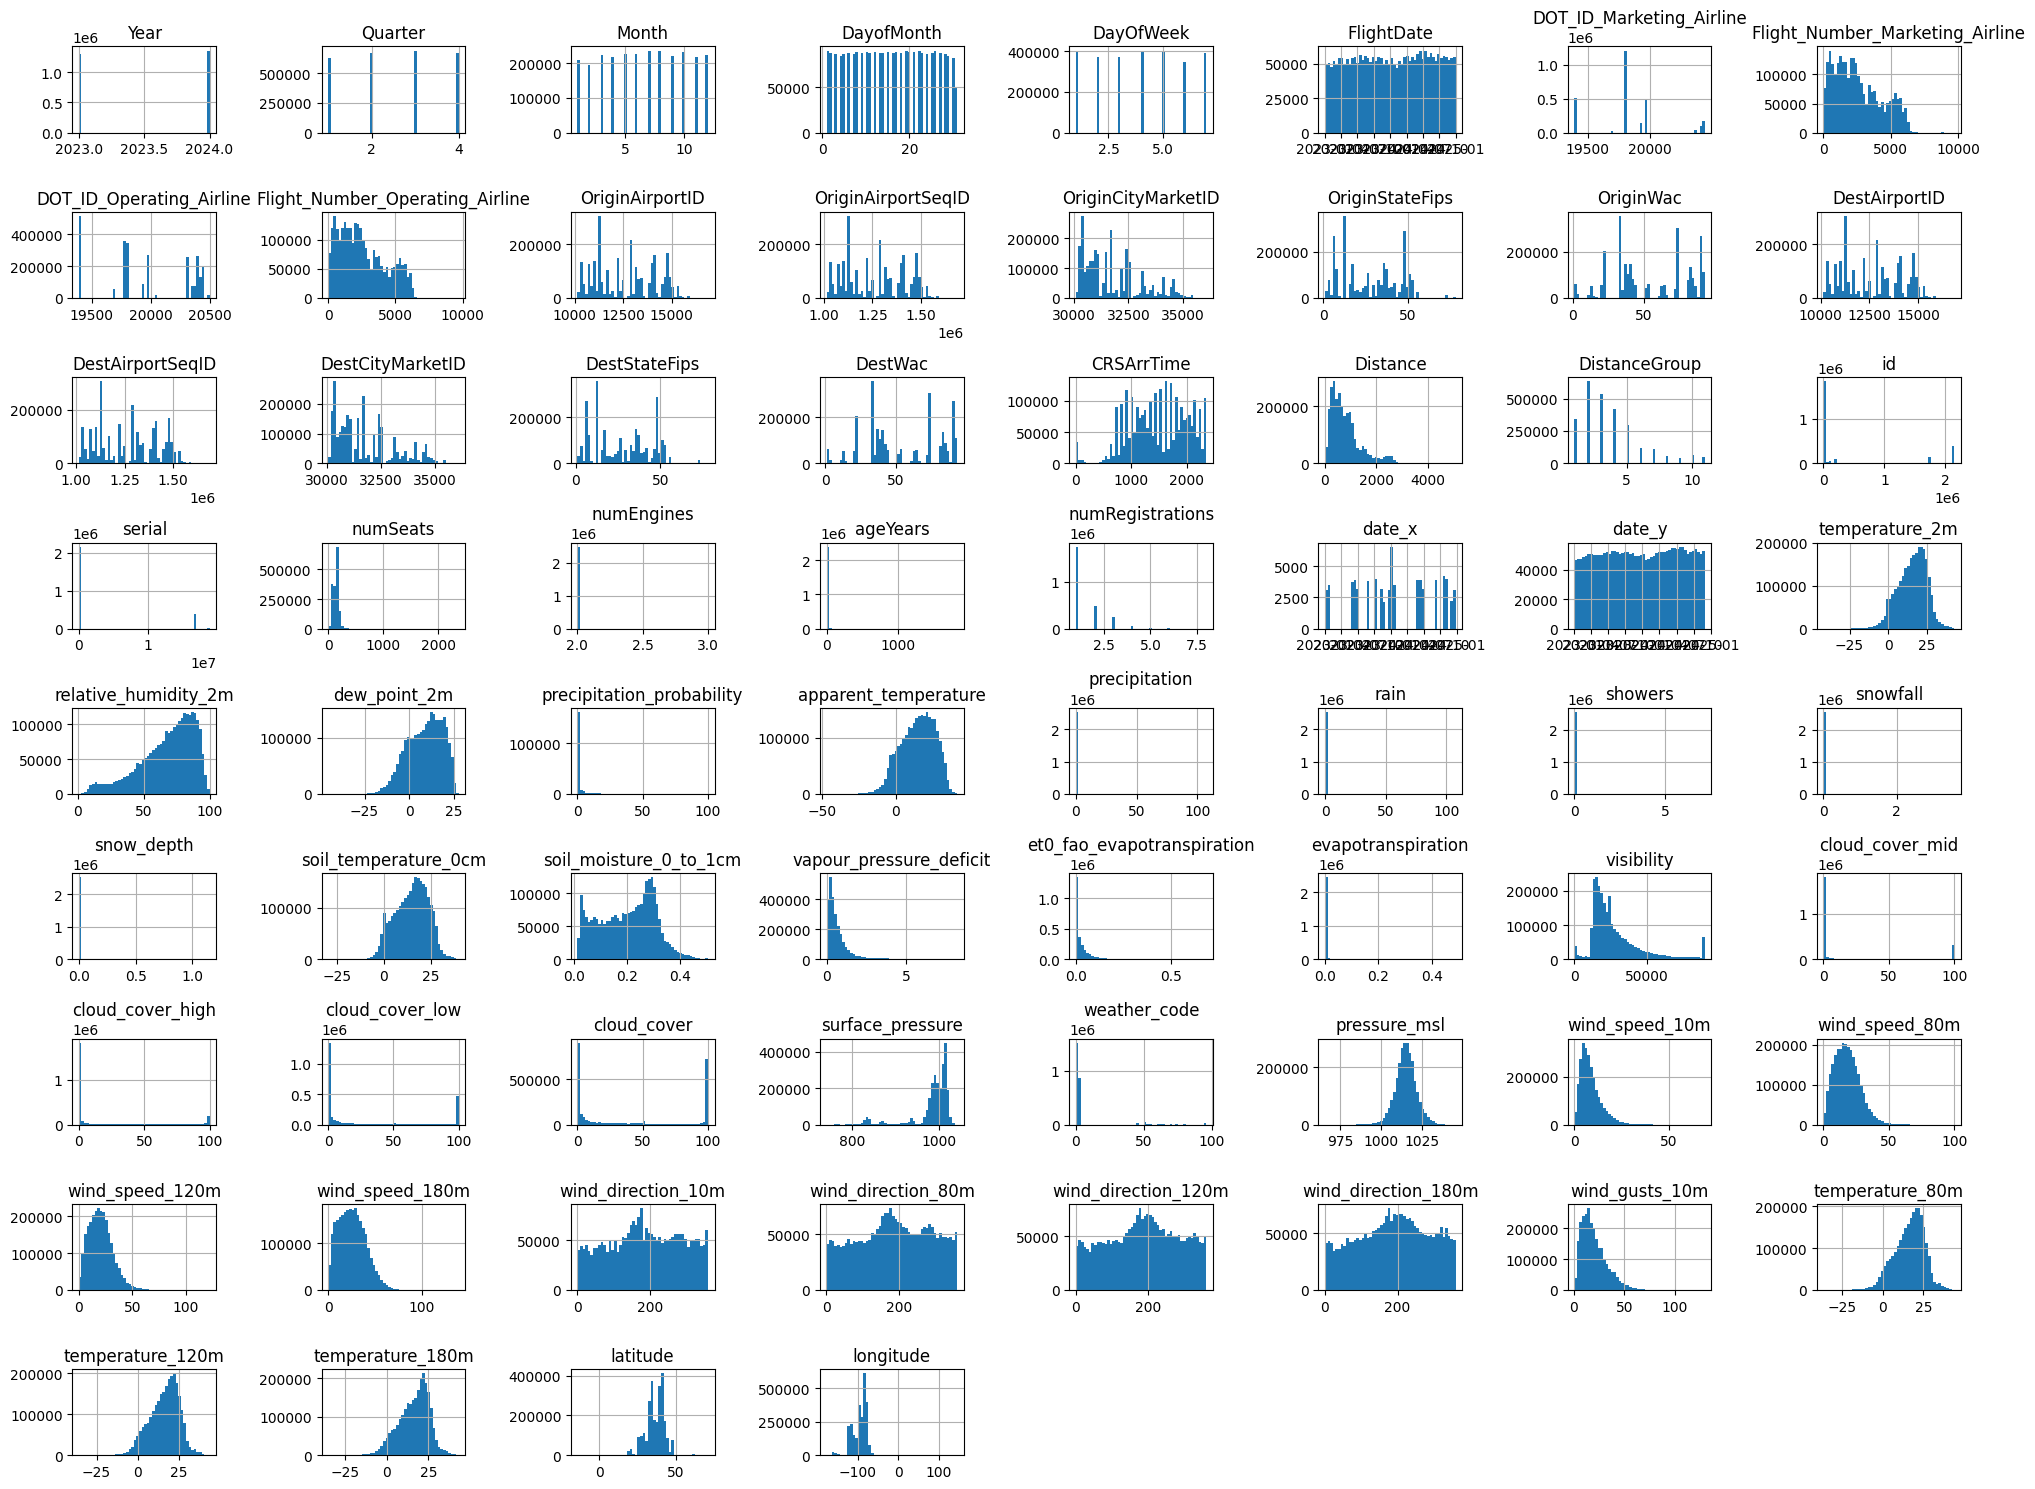

In [ ]:
train_data.hist(bins=50, figsize=(20,15))
plt.tight_layout()

/jupyterhub/lib64/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)


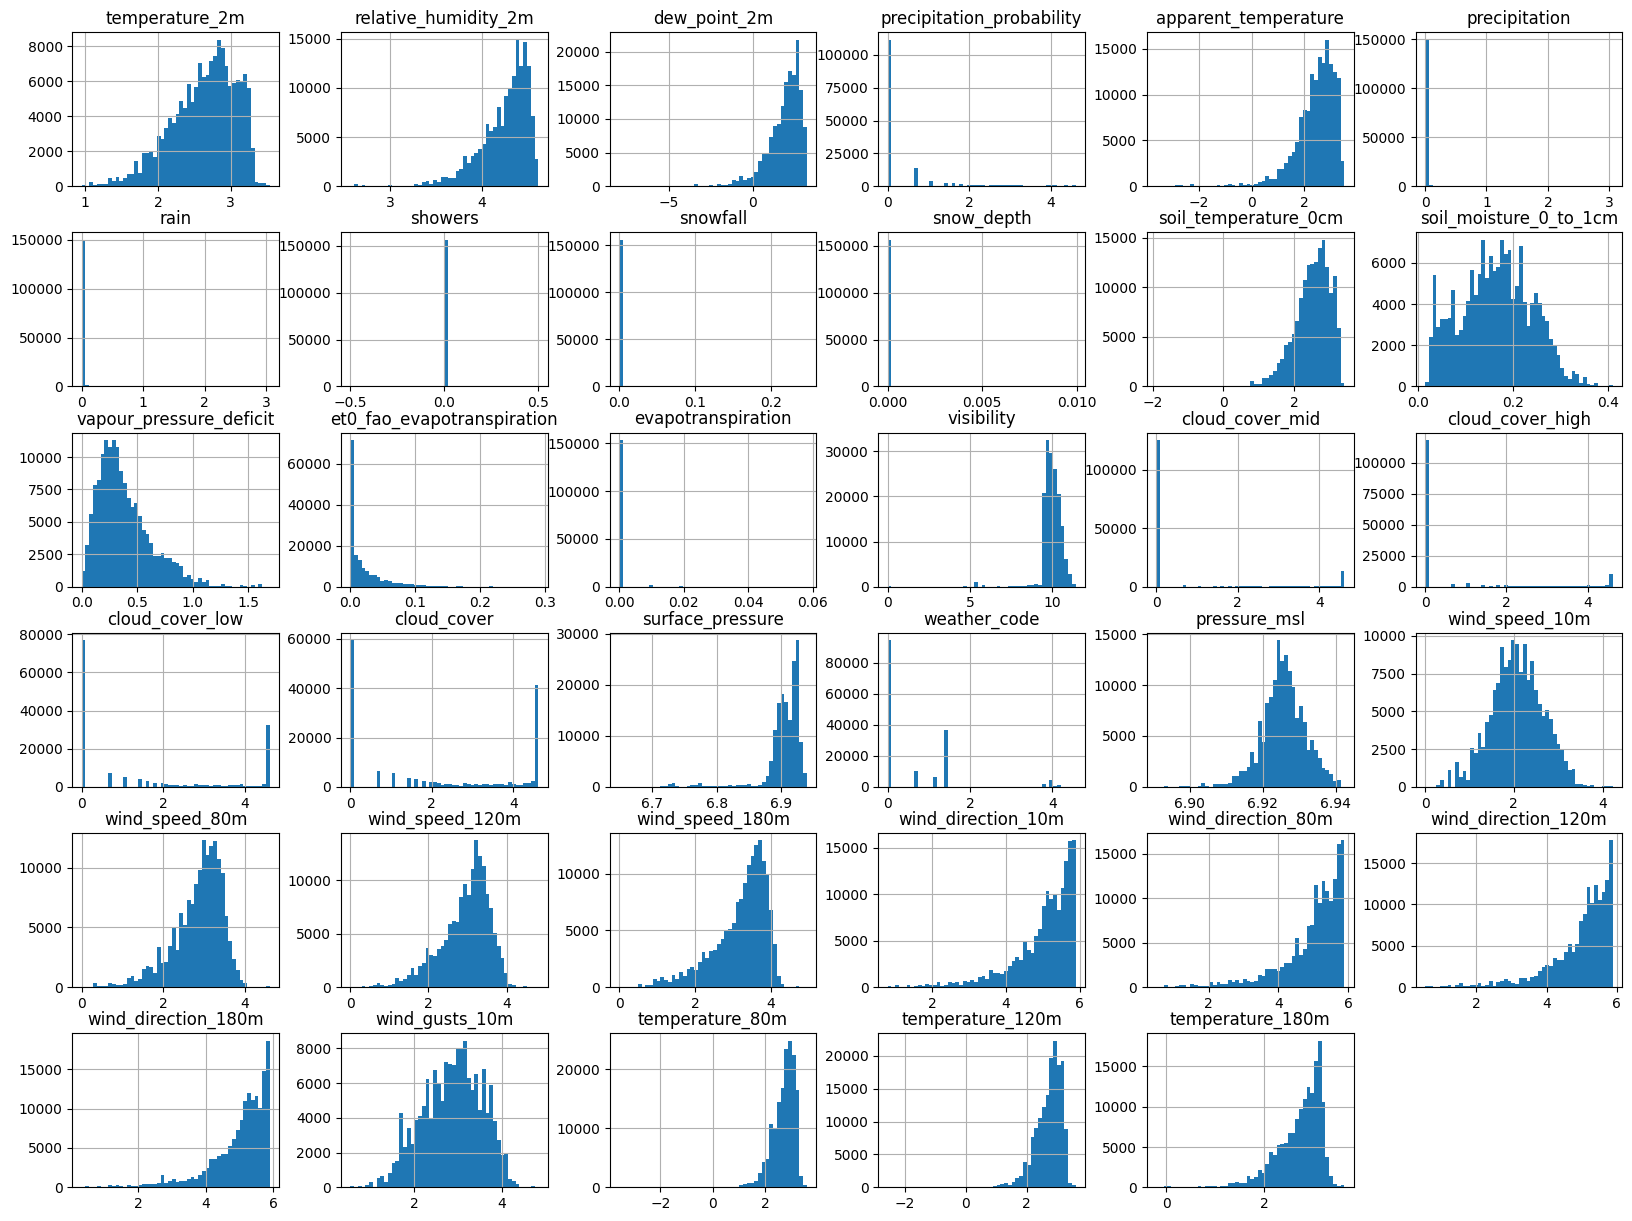

In [ ]:
# Select relevant columns
columns = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "precipitation_probability", "apparent_temperature",
    "precipitation", "rain", "showers", "snowfall", "snow_depth",
    "soil_temperature_0cm", "soil_moisture_0_to_1cm", "vapour_pressure_deficit",
    "et0_fao_evapotranspiration", "evapotranspiration", "visibility",
    "cloud_cover_mid", "cloud_cover_high", "cloud_cover_low", "cloud_cover",
    "surface_pressure", "weather_code", "pressure_msl",
    "wind_speed_10m", "wind_speed_80m", "wind_speed_120m", "wind_speed_180m",
    "wind_direction_10m", "wind_direction_80m", "wind_direction_120m", "wind_direction_180m",
    "wind_gusts_10m", "temperature_80m", "temperature_120m", "temperature_180m"
]

# Filter out values < -1 (as log1p is invalid for them)
filtered_data = train_data[columns].copy()
filtered_data[filtered_data < -1] = np.nan  # Replace invalid values with NaN

# Apply log1p transformation
log_transformed = np.log1p(filtered_data)

# Ensure no -inf values exist
log_transformed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values before plotting
log_transformed.dropna(inplace=True)

# Plot histogram
log_transformed.hist(bins=50, figsize=(20, 15))
plt.show()

Weather
==============

<Axes: >

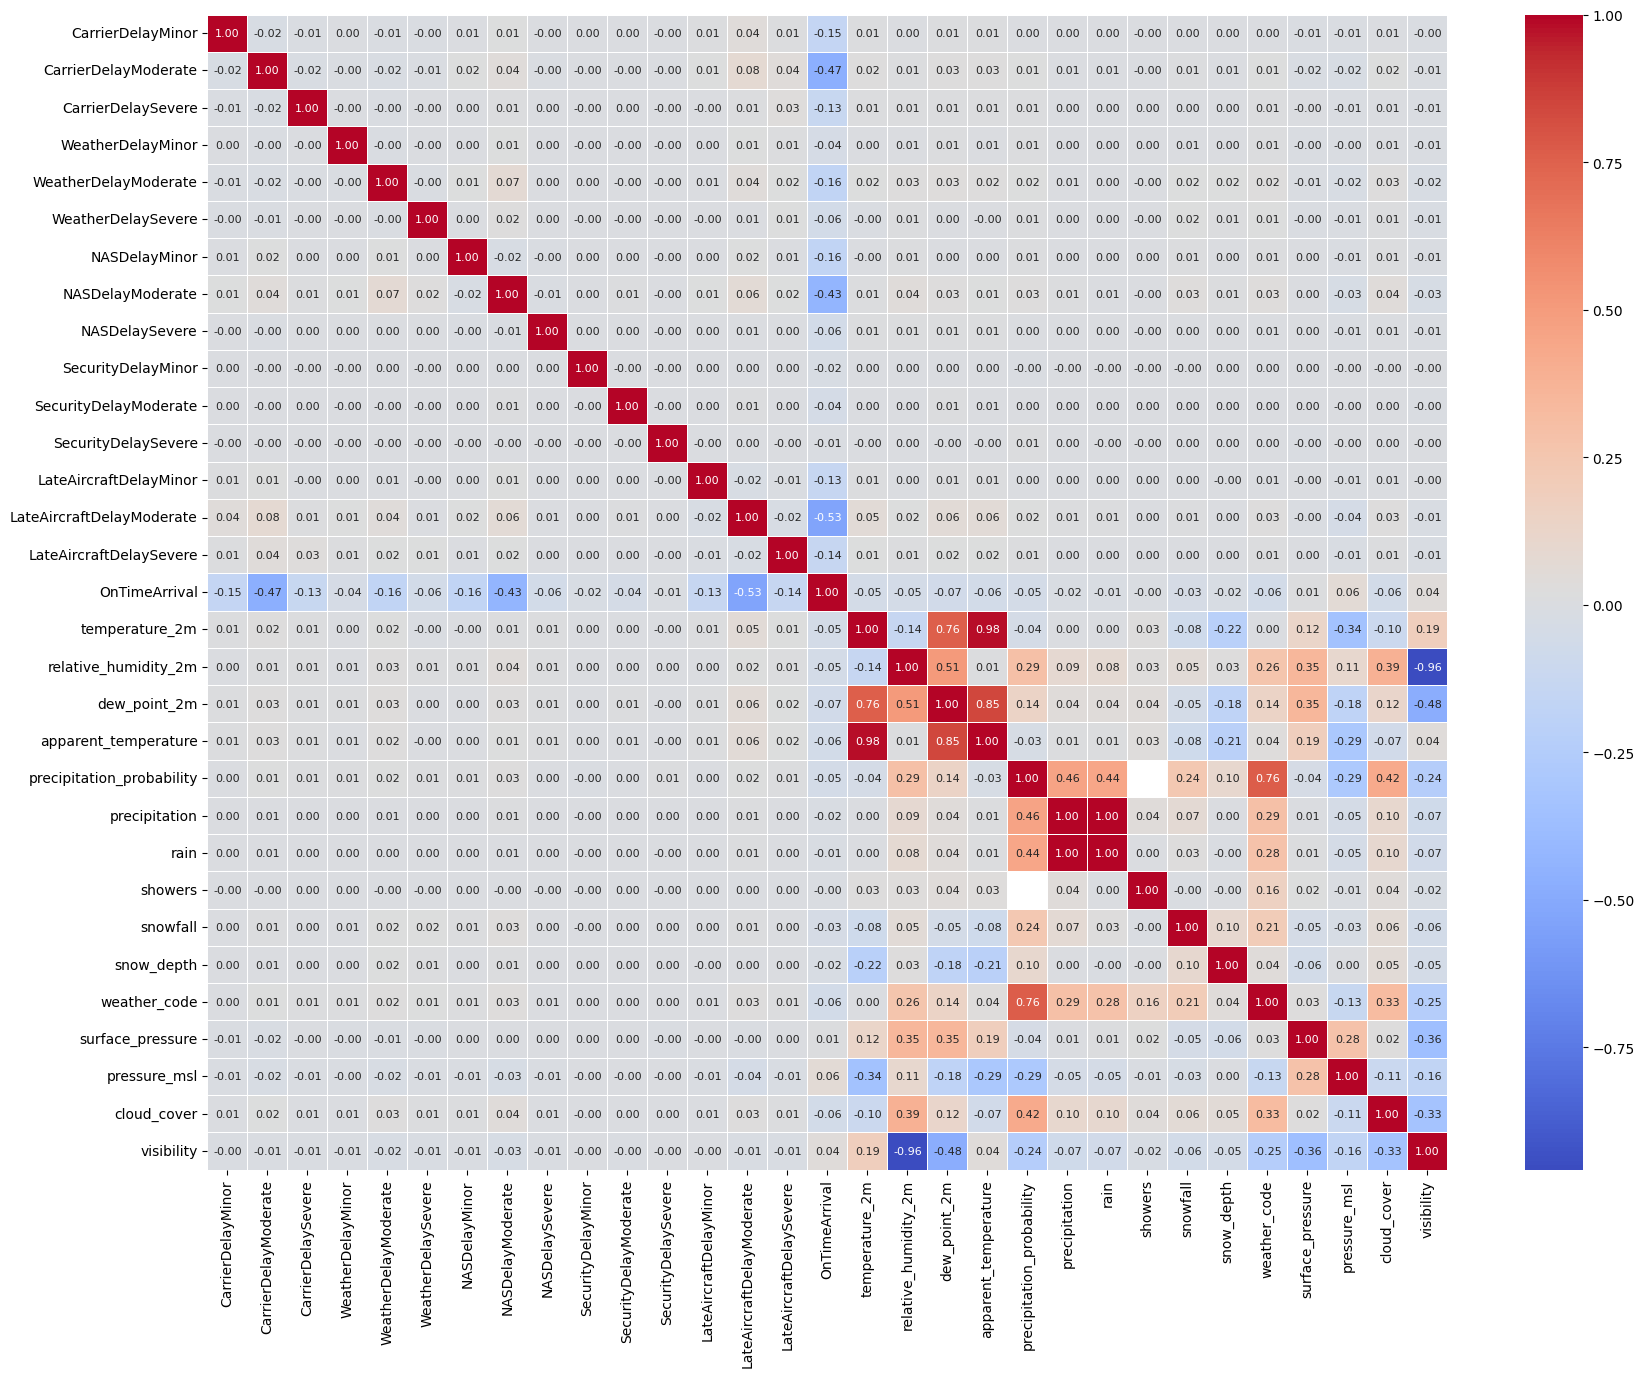

In [ ]:
# heatmap of delay columns and weather columns

plt.figure(figsize=(20,15))
sns.heatmap(train_data[[
    'CarrierDelayMinor', 'CarrierDelayModerate', 'CarrierDelaySevere', 
    'WeatherDelayMinor', 'WeatherDelayModerate', 'WeatherDelaySevere', 
    'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere', 
    'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere', 
    'LateAircraftDelayMinor', 'LateAircraftDelayModerate', 'LateAircraftDelaySevere', 
    'OnTimeArrival','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 
    'precipitation_probability', 'precipitation', 'rain', 'showers', 'snowfall', 'snow_depth', 'weather_code', 
    'surface_pressure', 'pressure_msl', 'cloud_cover', 'visibility'
]].corr(),annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    annot_kws={"size": 8}  # Adjust annotation font size for better readability
)


In [ ]:
train_data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       ...
       'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere',
       'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere',
       'LateAircraftDelayMinor', 'LateAircraftDelayModerate',
       'LateAircraftDelaySevere', 'OnTimeArrival'],
      dtype='object', length=123)

In [ ]:
# graph the weather delay columns against the different weather columns no need to log as a line graph
weather_delay_cols= ["WeatherDelayMinor","WeatherDelayModerate","WeatherDelaySevere"]

train_data.plot(kind="bar", x="WeatherDelayMinor", y="precipitation", alpha=0.1, figsize=(10, 6))


# for column in delay_cols:
#     train_data.plot(kind="scatter", x=WeatherDelayMinor, y="precipitation", alpha=0.1, figsize=(10, 6))
#     plt.title(f'{column} vs Precipitation')
#     plt.show()

Aircrafts
==============

In [ ]:

# train_data["VELOCITY"] = train_data["DISTANCE"] / train_data["AIR_TIME"]
# # remove infinite values
# flight_data = train_data[train_data["VELOCITY"] != float('inf')]
# flight_data["VELOCITY"].describe()

In [ ]:
# aircrafts_velo_dist = list()
# aircrafts_dist_time = list()
# aircrafts_velo_time = list()
# for aircraft in flight_data["AIRCRAFT_TYPE"].unique():
#     aircraft_data = flight_data[flight_data["AIRCRAFT_TYPE"] == aircraft]
#     corr_matrix = aircraft_data[["VELOCITY", "DISTANCE"]].corr()
#     aircrafts_velo_dist.append((aircraft, corr_matrix["DISTANCE"]["VELOCITY"]))
#     aircrafts_dist_time.append((aircraft, corr_matrix["DISTANCE"]["AIR_TIME"]))
#     aircrafts_velo_time.append((aircraft, corr_matrix["VELOCITY"]["AIR_TIME"]))
# # bar graph of aircrafts
# aircrafts = pd.DataFrame(aircrafts_velo_dist, columns=["AIRCRAFT_TYPE", "CORR"])
# sns.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)
# aircrafts = pd.DataFrame(aircrafts_velo_time, columns=["AIRCRAFT_TYPE", "CORR"])
# sns.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)
# aircrafts = pd.DataFrame(aircrafts_dist_time, columns=["AIRCRAFT_TYPE", "CORR"])
# sns.barplot(x="AIRCRAFT_TYPE", y="CORR", data=aircrafts)


- Some aircrafts are well correlated with distance and others are not
- we could categorize these air crafts
- most aircrafts go slower the longer the air time
- longer distances are done at faster speeds for most aircrafts

## Time of Year/ Seasonality

In [ ]:
# Convert relevant columns to categorical data types
categorical_cols = ["Marketing_Airline_Network", "Origin", "OriginCityName"]
train_data[categorical_cols] = train_data[categorical_cols].astype("category")
categorical_cols.append("Operating_Airline")
### 1. Temporal Patterns (Delays by Time of Year, Month, Day) ###
plt.figure(figsize=(12, 6))
sns.countplot(x="Month", data=train_data, palette="Blues")
plt.title("Flight Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="DayOfWeek", data=train_data, palette="Blues")
plt.title("Flight Distribution by Day of Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Flights")
plt.show()

### 2. Airline Performance (Delays by Airline) ###
plt.figure(figsize=(12, 6))
train_data["Marketing_Airline_Network"].value_counts().plot(kind="bar", color="blue", alpha=0.7)
plt.title("Flight Count by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.show()


### 4. Identifying Seasonal Trends in Delays ###
# Assuming you have a column `Delayed` where 1 = delayed, 0 = on-time
if "Delayed" in train_data.columns:
    monthly_delays = train_data.groupby("Month")["Delayed"].mean()
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=monthly_delays.index, y=monthly_delays.values, marker="o", color="red")
    plt.title("Average Delay Rate by Month")
    plt.xlabel("Month")
    plt.ylabel("Proportion of Delayed Flights")
    plt.show()

### 5. Code-Share & Connection Issues ###
if "Originally_Scheduled_Code_Share_Airline" in train_data.columns:
    plt.figure(figsize=(12, 6))
    train_data["Originally_Scheduled_Code_Share_Airline"].value_counts().nlargest(10).plot(kind="bar", color="purple", alpha=0.7)
    plt.title("Top 10 Code-Share Airlines")
    plt.xlabel("Code-Share Airline")
    plt.ylabel("Number of Flights")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
train_data.info()

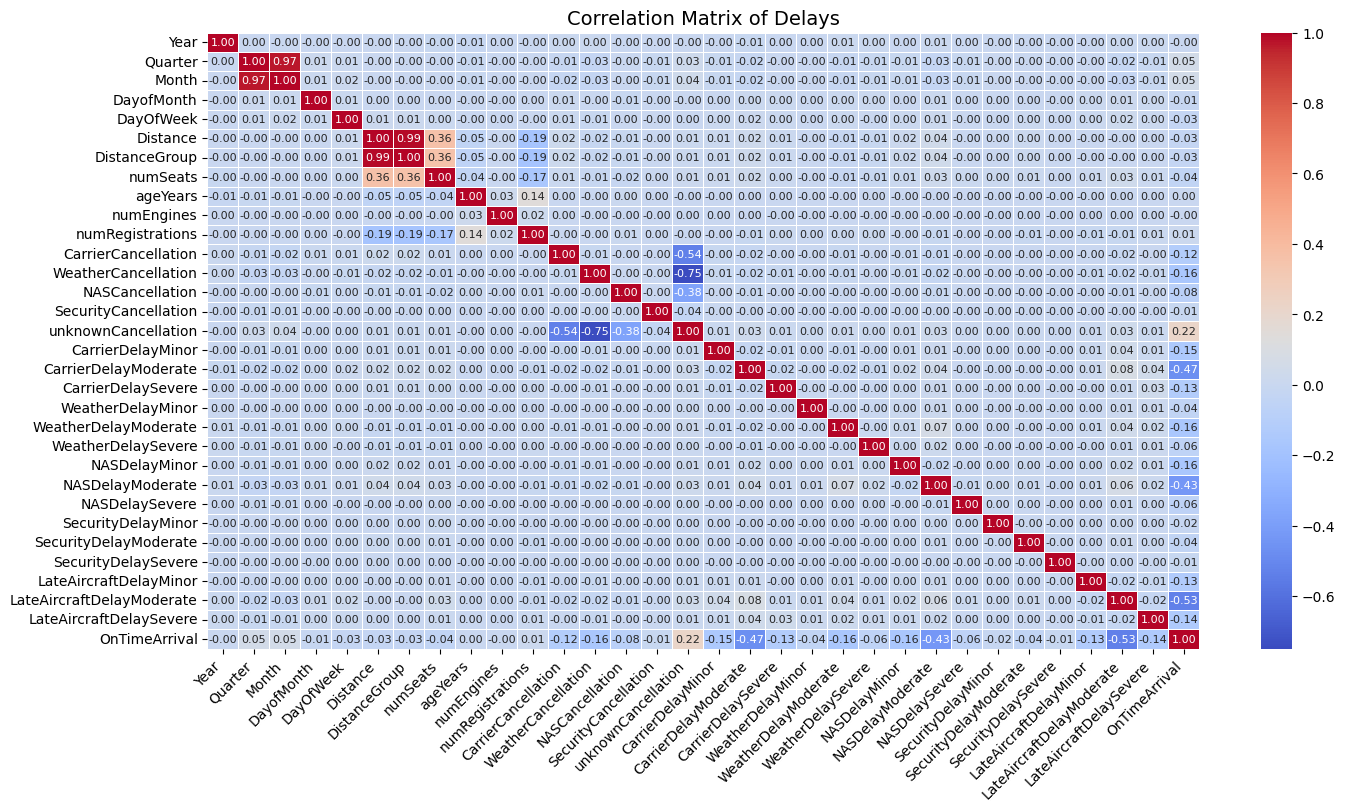

In [ ]:
### 6. Heatmap for different delays as x-axis and other columns as y-axis ###

heatmap_columns = [
    "Year", "Quarter", "Month", "DayofMonth", "DayOfWeek", "Distance", "DistanceGroup",
    "numSeats", "ageYears", "numEngines", "numRegistrations",
    "CarrierCancellation", "WeatherCancellation", "NASCancellation", "SecurityCancellation",
    "unknownCancellation", "CarrierDelayMinor", "CarrierDelayModerate", "CarrierDelaySevere",
    "WeatherDelayMinor", "WeatherDelayModerate", "WeatherDelaySevere",
    "NASDelayMinor", "NASDelayModerate", "NASDelaySevere",
    "SecurityDelayMinor", "SecurityDelayModerate", "SecurityDelaySevere",
    "LateAircraftDelayMinor", "LateAircraftDelayModerate", "LateAircraftDelaySevere",
    "OnTimeArrival"
]

# Create a correlation matrix
corr_matrix = train_data[heatmap_columns].corr()

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    annot_kws={"size": 8}  # Adjust annotation font size for better readability
)
plt.title("Correlation Matrix of Delays", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()


In [ ]:
# 2023 seasonal trends with delays and cancellations

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average delays for each month
target_by_month = data_2023.groupby("Month")[target_columns].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
target_by_month.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2023")
plt.xlabel("Month")
plt.ylabel("Average Delay and Cancellation Rate")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()



In [ ]:
# 2023 seasonal trends with delays

delay_cols = ['CarrierDelayMinor', 'CarrierDelayModerate', 'CarrierDelaySevere', 'WeatherDelayMinor', 'WeatherDelayModerate', 'WeatherDelaySevere', 'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere', 'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere', 'LateAircraftDelayMinor', 'LateAircraftDelayModerate', 'LateAircraftDelaySevere']


# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average delays for each month
target_by_month = data_2023.groupby("Month")[delay_cols].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
target_by_month.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2023")
plt.xlabel("Month")
plt.ylabel("Average Delay")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()

In [ ]:
# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each month
target_by_month = data_2024.groupby("Month")[target_columns].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
target_by_month.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2024")
plt.xlabel("Month")
plt.ylabel("Average Delay")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()

In [ ]:
# 2024 seasonal trends with delays

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each month
target_by_month = data_2024.groupby("Month")[delay_cols].mean()

# Plot the average delays for each month
plt.figure(figsize=(15, 10))
target_by_month.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Month in 2024")
plt.xlabel("Month")
plt.ylabel("Average Delay")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title="Delays")
plt.show()

In [ ]:
# Map weather delays in 2023 with a histogram

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average weather delays for each month
monthly_weather_delays = data_2023.groupby("Month")[["WeatherDelayMinor", "WeatherDelayModerate", "WeatherDelaySevere"]].mean()


# Plot the average weather delays for each month
plt.figure(figsize=(15, 10))
monthly_weather_delays.plot(kind="bar", ax=plt.gca(), color="skyblue")
plt.title("Average Weather Delays by Month in 2023")
plt.xlabel("Month")
plt.ylabel("Average Weather Delay")
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()

# Map weather delays in 2024 with a histogram

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average weather delays for each month
monthly_weather_delays = data_2024.groupby("Month")[["WeatherDelayMinor", "WeatherDelayModerate", "WeatherDelaySevere"]].mean()

# Plot the average weather delays for each month
plt.figure(figsize=(15, 10))
monthly_weather_delays.plot(kind="bar", ax=plt.gca(), color="skyblue")
plt.title("Average Weather Delays by Month in 2024")
plt.xlabel("Month")
plt.ylabel("Average Weather Delay")
plt.xticks(range(0, 13))
plt.grid(True)
plt.show()



In [ ]:
train_data['DepHourofDay'] = (data['CRSDepTime']//100)

In [ ]:

# Filter data for 2023
train_data_2023 = train_data[train_data['Year'] == 2023]

# Select three columns for visualization
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek']

# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for idx, column in enumerate(viz_columns):
    ax = axes[idx]
    
    # Group data by column and calculate delay percentages
    temp = train_data_2023.groupby(column)['ArrDel15'].value_counts(normalize=True).rename('percentage') \
        .mul(100).reset_index().sort_values(column)
    
    # Create bar plots
    sns.barplot(x=column, y="percentage", hue="ArrDel15", data=temp, ax=ax)
    ax.set_ylabel('% delay/no-delay')
    ax.set_xlabel(column)
    ax.set_title(f'Percentage of Delay by {column} (2023)')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


In [ ]:
# Filter data for 2024
train_data_2023 = train_data[train_data['Year'] == 2024]

# Select three columns for visualization
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek']

# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for idx, column in enumerate(viz_columns):
    ax = axes[idx]
    
    # Group data by column and calculate delay percentages
    temp = train_data_2023.groupby(column)['ArrDel15'].value_counts(normalize=True).rename('percentage') \
        .mul(100).reset_index().sort_values(column)
    
    # Create bar plots
    seaborn.barplot(x=column, y="percentage", hue="ArrDel15", data=temp, ax=ax)
    ax.set_ylabel('% delay/no-delay')
    ax.set_xlabel(column)
    ax.set_title(f'Percentage of Delay by {column} (2024)')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [ ]:
# 2023 seasonal trends


# Function to categorize months into seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add a column to categorize the months into seasons
train_data['Season'] = train_data['Month'].apply(get_season)

# Filter data for 2023 and 2024 to focus on these years
train_data_filtered = train_data[train_data['Year'].isin([2023, 2024])]

# Group data by season and calculate the count of delays and non-delays
season_delay_data = train_data_filtered.groupby(['Season', 'Year', 'ArrDel15']).size().unstack(fill_value=0)

# Calculate the percentage of delays and non-delays by season
season_delay_data_percentage = season_delay_data.div(season_delay_data.sum(axis=1), axis=0) * 100

# Reset the index to flatten the DataFrame
season_delay_data_percentage = season_delay_data_percentage.reset_index()

# Check the structure of the data
print(season_delay_data_percentage.head())

# Create a plot for seasonal delay patterns
plt.figure(figsize=(12, 6))

# Now, plot the 'Delayed' column (adjusted to your actual delay label)
sns.barplot(x='Season', y=1, hue='Year', data=season_delay_data_percentage)

plt.title('Seasonal Delay Patterns by Year')
plt.ylabel('% Delayed Flights')
plt.xlabel('Season')
plt.legend(title='Year')
plt.show()


- Seemingly the Summer is when

## Holidays

In [ ]:
train_data['holiday'].unique()

In [ ]:
# List of federal holidays
list_of_federal_holidays = [
    "Thanksgiving", "Juneteenth", "Columbus Day", "Independence Day",
    "Christmas Day", "Memorial Day", "New Year's Day", "Veterans Day",
    "Labor Day", "Martin Luther King Jr. Day"
]

# Convert 'date' column to datetime if not already
train_data["date"] = pd.to_datetime(train_data["date"])

# Function to calculate holidays for a given year
def get_holiday_dates(year):
    # Helper function to get the nth weekday of a month
    def nth_weekday(year, month, weekday, n):
        """ Get the nth occurrence of a specific weekday in a given month/year. """
        first_day = pd.Timestamp(year=year, month=month, day=1)
        # Find the first occurrence of the given weekday
        first_occurrence = first_day + pd.DateOffset(days=(weekday - first_day.weekday()) % 7)
        return first_occurrence + pd.DateOffset(weeks=n-1)
    
    return {
        "Thanksgiving": nth_weekday(year, 11, 3, 4),  # 4th Thursday of November
        "Juneteenth": pd.Timestamp(year, 6, 19),
        "Columbus Day": nth_weekday(year, 10, 0, 2),  # 2nd Monday of October
        "Independence Day": pd.Timestamp(year, 7, 4),
        "Christmas Day": pd.Timestamp(year, 12, 25),
        "Memorial Day": nth_weekday(year, 5, 0, -1),  # Last Monday of May
        "New Year's Day": pd.Timestamp(year, 1, 1),
        "Veterans Day": pd.Timestamp(year, 11, 11),
        "Labor Day": nth_weekday(year, 9, 0, 1),  # 1st Monday of September
        "Martin Luther King Jr. Day": nth_weekday(year, 1, 0, 3)  # 3rd Monday of January
    }

def get_holiday_week(date):
    if pd.isna(date):  # Check if the date is None or NaT
        return None  # Return None so it doesn't cause an error

    year = date.year  # Get the year of the date
    holiday_dates = get_holiday_dates(year)  # Generate holiday dates for that year
    for holiday, holiday_date in holiday_dates.items():
        if holiday_date - pd.Timedelta(days=3) <= date <= holiday_date + pd.Timedelta(days=3):
            return holiday
    return None  # Return None instead of "None" string


# Apply function to determine if each row falls within a holiday week
train_data["holiday_week"] = train_data["date"].apply(get_holiday_week)

In [ ]:
# Plot the distribution of flights by holiday week
plt.figure(figsize=(12, 6))
sns.countplot(x="holiday_week", data=train_data, palette="Blues")
plt.title("Flight Distribution by Holiday Week")
plt.xlabel("Holiday Week")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Plot the holiday week vs delays

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average delays for each holiday week
target_by_holiday_week = data_2023.groupby("holiday_week")[delay_cols].mean()

# Plot the average delays for each holiday week
plt.figure(figsize=(15, 10))
target_by_holiday_week.plot(kind="bar", ax=plt.gca())
plt.title("Average Delays by Holiday Week in 2023")
plt.xlabel("Holiday Week")
plt.ylabel("Average Delay")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Delays")
plt.show()

In [ ]:
# Plot the holiday week vs delays

# Filter the data for 2023
data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average delays for each holiday week
target_by_holiday_week = data_2023.groupby("holiday_week")[cancellation_cols].mean()

# Plot the average delays for each holiday week
plt.figure(figsize=(15, 10))
target_by_holiday_week.plot(kind="bar", ax=plt.gca())
plt.title("Average Cancellations by Holiday Week in 2023")
plt.xlabel("Holiday Week")
plt.ylabel("Average Cancellation")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Cancellation")
plt.show()

In [ ]:
# Plot the holiday week vs delays

# Filter the data for 2024
data_2024= train_data[train_data["Year"] == 2024]

# Calculate the average delays for each holiday week
target_by_holiday_week = data_2024.groupby("holiday_week")[delay_cols].mean()

# Plot the average delays for each holiday week
plt.figure(figsize=(15, 10))
target_by_holiday_week.plot(kind="bar", ax=plt.gca())
plt.title("Average Delays by Holiday Week in 2024")
plt.xlabel("Holiday Week")
plt.ylabel("Average Delay")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Delays")
plt.show()

In [ ]:
# Plot the holiday week vs cancellations

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average cancellations for each holiday week
target_by_holiday_week = data_2024.groupby("holiday_week")[cancellation_cols].mean()

# Plot the average cancellations for each holiday week
plt.figure(figsize=(15, 10))
target_by_holiday_week.plot(kind="bar", ax=plt.gca())
plt.title("Average Cancellations by Holiday Week in 2024")
plt.xlabel("Holiday Week")
plt.ylabel("Average Cancellation")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Cancellation")
plt.show()

In [ ]:
# Graph on-time arrival by holiday week

# Filter the data for 2023

data_2023 = train_data[train_data["Year"] == 2023]

# Calculate the average arrival for each holiday week

target_by_holiday_week = data_2023.groupby("holiday_week")["OnTimeArrival"].mean()

# Plot the average arrival for each holiday week

plt.figure(figsize=(15, 10))

target_by_holiday_week.plot(kind="bar", ax=plt.gca())

plt.title("On-Time Arrival by Holiday Week in 2023")

plt.xlabel("Holiday Week")
plt.ylabel("On-Time Arrival")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="On-Time Arrival")
plt.show()

In [ ]:
# Graph on-time arrival by holiday week

# Filter the data for 2024

data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average arrival for each holiday week

target_by_holiday_week = data_2024.groupby("holiday_week")["OnTimeArrival"].mean()

# Plot the average arrival for each holiday week

plt.figure(figsize=(15, 10))

target_by_holiday_week.plot(kind="bar", ax=plt.gca())

plt.title("On-Time Arrival by Holiday Week in 2024")

plt.xlabel("Holiday Week")
plt.ylabel("On-Time Arrival")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="On-Time Arrival")
plt.show()

## Aircraft vs Delays

In [ ]:
train_data.head()

In [ ]:
# Graph the aircrafts by tail number

train_data['Tail_Number'].value_counts().nlargest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Aircrafts by Tail Number')
plt.xlabel('Tail Number')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Drop Tail_Number with no delay
# train_data = train_data[train_data['NoDelay'] == 0]

In [ ]:
train_data.head()

In [ ]:
# # Plot planes with only minor delays
# train_data[train_data['MinorDelay'] == 1]['Tail_Number'].value_counts().nlargest(50).plot(kind='bar', color='skyblue', alpha=0.7)
# plt.title('Top 10 Aircrafts by Minor Delays')
# plt.xlabel('Tail Number')
# plt.ylabel('Number of Flights')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# Graph the lowest 10 aircrafts by tail number

train_data['Tail_Number'].value_counts().nsmallest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Bottom 10 Aircrafts by Tail Number')
plt.xlabel('Tail Number')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Aggregate the data to get the average delays per tail number
tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Sort by highest average delay
tail_number_delays = tail_number_delays.sort_values("DepDelayMinutes", ascending=False)

# Select the top 50 tail numbers with the highest departure delays
top_tail_numbers = tail_number_delays.head(50)

# Scatter plot
plt.figure(figsize=(18, 6))
plt.scatter(top_tail_numbers.index, top_tail_numbers["DepDelayMinutes"], color="blue", label="Departure Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["ArrDelayMinutes"], color="red", label="Arrival Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["CarrierDelay"], color="green", label="Carrier Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["WeatherDelay"], color="purple", label="Weather Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["NASDelay"], color="orange", label="NAS Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["SecurityDelay"], color="brown", label="Security Delay", alpha=0.7)
plt.scatter(top_tail_numbers.index, top_tail_numbers["LateAircraftDelay"], color="black", label="Late Aircraft Delay", alpha=0.7)

# Improve readability
plt.xticks(rotation=90)
plt.xlabel("Tail Number")
plt.ylabel("Average Delay (minutes)")
plt.title("Top 50 Tail Numbers with the Highest Delays in 2024")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [ ]:
# Aggregate by Tail Number (or another category)
tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Sort by average departure delay for better visualization
tail_number_delays = tail_number_delays.sort_values("DepDelayMinutes")

# Select the top 50 tail numbers for clarity
top_tail_numbers = tail_number_delays.head(50)

# Increase figure width for better spacing
plt.figure(figsize=(20, 8))  

# Set bar width
bar_width = 0.4  

# Create x positions
x = range(len(tail_number_delays))

# Plot side-by-side bars
plt.bar(x, tail_number_delays["DepDelayMinutes"], width=bar_width, label="Departure Delay", color="blue", alpha=0.7)
plt.bar([i + bar_width for i in x], tail_number_delays["ArrDelayMinutes"], width=bar_width, label="Arrival Delay", color="red", alpha=0.7)

# Improve x-axis labels
# plt.xticks([i + bar_width / 2 for i in x], top_tail_numbers.index, rotation=90)

plt.title("Top 50 Tail Numbers by Average Delays in 2024")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Tail Number")
plt.legend(title="Delay Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
# Correlation between delays and Tail Number

# Filter the data for 2024

data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each tail number

tail_number_delays = data_2024.groupby("Tail_Number")[delays].mean()

# Calculate the correlation matrix

corr_matrix = tail_number_delays.corr()

# Plot the heatmap

plt.figure(figsize=(12, 6))

seaborn.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Matrix of Delays by Tail Number in 2024")

plt.show()



In [ ]:
# Graph the aircrafts with the highest age

train_data['ageYears'].value_counts().nlargest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Aircrafts by Age')
plt.xlabel('Age in Years')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# create new columns for different cancellation reasons A for carrier, B for weather, C for NAS, D for security
train_data['CarrierCancellation'] = train_data['CancellationCode'] == 'A'
train_data['WeatherCancellation'] = train_data['CancellationCode'] == 'B'
train_data['NASCancellation'] = train_data['CancellationCode'] == 'C'
train_data['SecurityCancellation'] = train_data['CancellationCode'] == 'D'

# if the cancellation code is missing, it is unknown
train_data['unknownCancellation'] = train_data['CancellationCode'].isnull()

In [ ]:
# histogram for the different cancellation reasons, CarrierCancellation, WeatherCancellation, NASCancellation, SecurityCancellation for comparison

# Create a list of the columns to plot
cancellation_cols = ['CarrierCancellation', 'WeatherCancellation', 'NASCancellation', 'SecurityCancellation']

# Create a histogram for each column

train_data[cancellation_cols].sum().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Cancellation Reasons')
plt.xlabel('Cancellation Reason')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

In [ ]:


# Ensure necessary columns exist
if {'active', 'ageYears', 'model'}.issubset(train_data.columns):
    # Filter only active aircraft and exclude unrealistic ages
    active_aircraft = train_data[(train_data['active'] == True) & (train_data['ageYears'] <= 100)]

    # Group by aircraft model and get the max age per model
    oldest_models = active_aircraft.groupby('model')['ageYears'].max().nlargest(20)

    # Plot as a horizontal bar chart for better readability
    plt.figure(figsize=(12, 8))
    oldest_models.sort_values().plot(kind='barh', color='skyblue')

    plt.xlabel("Aircraft Age (Years)")
    plt.ylabel("Aircraft Model")
    plt.title("Oldest Active Aircraft by Model (≤ 100 Years)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

else:
    print("Required columns ('active', 'ageYears', 'model') are missing in the DataFrame.")


In [ ]:

# Ensure required columns exist
required_cols = {'active', 'ageYears', 'model'} | set(cancellation_cols)
if required_cols.issubset(train_data.columns):
    # Filter for active aircraft ≤ 100 years old
    active_aircraft = train_data[(train_data['active'] == True) & (train_data['ageYears'] <= 100)]
    
    # Group by aircraft model and sum cancellations
    cancellation_counts = active_aircraft.groupby('model')[cancellation_cols].sum()

    # Get the 10 oldest aircraft models
    oldest_models = active_aircraft.groupby('model')['ageYears'].max().nlargest(20).index
    
    # Filter cancellation data for these oldest aircraft
    oldest_cancellations = cancellation_counts.loc[oldest_models]

    # Plot as a grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    bar_width = 0.2
    x = np.arange(len(oldest_models))  # Bar positions
    
    # Plot each cancellation type
    for i, col in enumerate(cancellation_cols):
        ax.bar(x + i * bar_width, oldest_cancellations[col], width=bar_width, label=col)

    # Format the graph
    ax.set_xlabel("Aircraft Model")
    ax.set_ylabel("Number of Cancellations")
    ax.set_title("Cancellations by Type for the Oldest Active Aircraft")
    ax.set_xticks(x + bar_width * (len(cancellation_cols) / 2))
    ax.set_xticklabels(oldest_models, rotation=45, ha="right")
    ax.legend(title="Cancellation Type")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

else:
    print(f"Missing required columns: {required_cols - set(train_data.columns)}")


In [ ]:

# Filter the data for the B738 model
b738_data = train_data[train_data['model'] == 'B738']

# Group by year and calculate the average delay
b738_delays = b738_data.groupby('Year')[[
    'CarrierDelayMinor', 'CarrierDelayModerate', 'CarrierDelaySevere',
    'WeatherDelayMinor', 'WeatherDelayModerate', 'WeatherDelaySevere',
    'NASDelayMinor', 'NASDelayModerate', 'NASDelaySevere',
    'SecurityDelayMinor', 'SecurityDelayModerate', 'SecurityDelaySevere',
    'LateAircraftDelayMinor', 'LateAircraftDelayModerate', 'LateAircraftDelaySevere'
]].mean()

# Set up figure
plt.figure(figsize=(14, 6))
bar_width = 0.07  # Adjust bar width for better spacing
x = np.arange(len(b738_delays.index))  # X positions for years

# Plot each delay type as a separate bar
for i, col in enumerate(b738_delays.columns):
    plt.bar(x + i * bar_width, b738_delays[col], width=bar_width, label=col)

# Formatting
plt.xticks(x + (len(b738_delays.columns) / 2) * bar_width, b738_delays.index, rotation=45)
plt.xlabel('Year')
plt.ylabel('Average Delay')
plt.title('Average Delays for Model B738 by Year')
plt.legend(title='Delay Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Compare the different delay types for the oldest aircraft models

# Ensure required columns exist
required_cols = {'active', 'ageYears', 'model'} | set(delay_cols)
if required_cols.issubset(train_data.columns):
    # Filter for active aircraft ≤ 100 years old
    active_aircraft = train_data[(train_data['active'] == True) & (train_data['ageYears'] <= 100)]
    
    # Group by aircraft model and sum delays
    delay_counts = active_aircraft.groupby('model')[delay_cols].sum()

    # Get the 20 oldest aircraft models
    oldest_models = active_aircraft.groupby('model')['ageYears'].max().nlargest(20).index
    
    # Filter delay data for these oldest aircraft
    oldest_delays = delay_counts.loc[oldest_models]

    # Plot as a grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    bar_width = 0.2
    x = np.arange(len(oldest_models))  # Bar positions
    
    # Plot each delay type
    for i, col in enumerate(delay_cols):
        ax.bar(x + i * bar_width, oldest_delays[col], width=bar_width, label=col)

    # Format the graph
    ax.set_xlabel("Aircraft Model")
    ax.set_ylabel("Total Delay Time (Minutes)")
    ax.set_title("Delays by Type for the Oldest Active Aircraft")
    ax.set_xticks(x + bar_width * (len(delay_cols) / 2))
    ax.set_xticklabels(oldest_models, rotation=45, ha="right")
    ax.legend(title="Delay Type")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

else:
    print(f"Missing required columns: {required_cols - set(train_data.columns)}")



In [ ]:
model_CRJ2 = train_data[train_data['model'] == 'CRJ2']

# age

model_CRJ2['ageYears'].value_counts().nlargest(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 CRJ2 Aircrafts by Age')
plt.xlabel('Age in Years')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# ageYears vs delays

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each age
age_delays = data_2024[data_2024["ageYears"]< 500].groupby("ageYears")[delays].mean()

# Plot the average delays for each age
plt.figure(figsize=(15, 10))
age_delays.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Age in 2024")
plt.xlabel("Age in Years")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.legend(title="Delays")
plt.show()


In [ ]:
# ageYears vs delays
delays = ['DepDelayMinutes', 'ArrDelayMinutes']

# Filter the data for 2024
data_2024 = train_data[train_data["Year"] == 2024]

# Calculate the average delays for each age greater than 500 years
age_delays = data_2024[data_2024["ageYears"]> 500].groupby("ageYears")[delays].mean()

# Plot the average delays for each age
plt.figure(figsize=(15, 10))
age_delays.plot(kind="line", marker="o", ax=plt.gca())
plt.title("Average Delays by Age in 2024")
plt.xlabel("Age in Years")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.legend(title="Delays")
plt.show()

- There are age values as high as 1800 this is clearly not correct.

Individual Attributes
=====================
\* Dervived from the other features

Air Crafts
----------
| Attribute             | Type        | Missing | Noise | Use  | Distribution             |
| --------------------- | ----------- | ------- | ----- | ---- | ------------------------ |
| id                    | Text        | None    | None  |      | Unique except 50 doubles |
| reg                   | Text        | None    | None  |      | Unique                   |
| active                | Boolean     | None    | None  |      | 93% true                 |
| serial                | Text        | 14      | None  |      | Unique                   |
| hexIcao               | Text        | 32      | None  |      | Unique                   |
| airlineName           | Categorical | None    | None  | high | Top heavy                |
| iataCodeShort         | Categorical | 2%      | None  |      | Top heavy                |
| icaoCode              | Categorical | 7%      | None  |      | Top heavy                |
| model                 | Categorical | 3%      | None  |      | Top heavy                |
| modelCode             | Categorical | 14      | None  |      | Exponential decay        |
| numSeats              | Int         | 34%     | None  |      | Loosely normal           |
| rolloutDate           | Date        | 29%     | None  |      | Unique                   |
| firstFlightDate       | Date        | 37%     | None  |      |                          |
| deliveryDate          | Date        | 17%     | None  |      |                          |
| registrationDate      | Date        | 39      | None  |      |                          |
| typeName              | Categorical | None    | None  |      | Top heavy                |
| numEngines            | Int         | 3%      | None  |      | All but 5 the same       |
| engineType            | Categorical | 3%      | None  |      | Nearly all the same      |
| isFreighter           | Boolean     | None    | None  |      | 36 Trues                 |
| productionLine        | Categorical | 2%      | None  |      | Top heavy                |
| ageYears              | Float       | 5%      | .1    |      | Peaks and Valleys        |
| verified              | Boolean     | None    | None  |      | 29 false values          |
| numRegistrations      | Int         | None    | None  |      | low value top heavy      |
| firstRegistrationDate | Date        | 30      | None  |      | Near unique              |

Summary of the individual attributes of the weather data. Many more details are available in the analysis in the subsequent cells.

| Attribute                       | Type        | Missing | Noise       | Usefulness | Distribution |
| ------------------------------- | ----------- | ------- | ----------- | ---------- | ------------ |
| Year                            | Time        | None    | None        |            | Uniform      |
| Quarter                         | Time        | None    | None        |            | Uniform      |
| Month                           | Time        | None    | None        |            | Uniform      |
| DayofMonth                      | Time        | None    | None        |            | Uniform      |
| DayofWeek                       | Time        | None    | None        |            | Uniform      |
| FlightDate                      | Time        | None    | Rounded Day | High       | Uniform      |
| Marketing_Airline_Network       | Categorical | None    | None        |            | Top Heavy    |
| Operated_or_Branded_Code...     | Categorical | None    | None        |            | Top Heavy    |
| DOT_ID_Marketing_Airline        | ID          | None    | None        |            | None         |
| IATA_Code_Marketing_Airline     | Categorical | None    | None        |            | Top Heavy    |
| Flight_Number_Marketing_Airline | ID          | None    | None        |            | None         |
| Originally_Scheduled_Code...    | Categorical | 99%     | None        | Cannot Use | None         |
| DOT_ID_Originally...            | ID          | 99%     | None        | Cannot Use | None         |
| IATA_Code_Originally...         | Categorical | 99%     | None        | Cannot Use | None         |
| Flight_Num_Originally...        | ID          | 99%     | None        | Cannot Use | None         |
| Operating_Airline               | Categorical | None    | None        |            | None         |
| DOT_ID_Operating_Airline        | ID          | None    | None        |            | None         |
| IATA_Code_Operating_Airline     | Categorical | None    | None        |            | None         |
| Tail_Number                     | ID          | None    | None        |            | Distinct     |
| Flight_Number_Operating_Airline | ID          | None    | None        |            | Distinct     |
| OriginAirportID                 | ID          | None    | None        |            | Distinct     |
| OriginAirportSeqID              | ID          | None    | None        |            | Distinct     |
| OriginCityMarketID              | ID          | None    | None        |            | None         |
| Origin                          | Categorical | None    | None        |            | None         |
| OriginCityName                  | Categorical | None    | None        |            | None         |
| OriginState                     | Categorical | None    | None        |            | None         |
| OriginStateFips                 | Categorical | None    | None        |            | None         |
| OriginStateName                 | Categorical | None    | None        |            | None         |
| OriginWac                       | Categorical | None    | None        |            | None         |
| DestAirportID                   | ID          | None    | None        |            | None         |
| DestAirportSeqID                | ID          | None    | None        |            | None         |
| DestCityMarketID                | ID          | None    | None        |            | None         |
| Dest                            | Categorical | None    | None        |            | None         |
| DestCityName                    | Categorical | None    | None        |            | None         |
| DestState                       | Categorical | None    | None        |            | None         |
| DestStateFips                   | Categorical | None    | None        |            | None         |
| DestStateName                   | Categorical | None    | None        |            | None         |
| DestWac                         | Categorical | None    | None        |            | None         |
| CRSDepTime                      | Time        | None    | None        | Cannot Use | None         |
| DepTime                         | Time        | None    | None        | Cannot Use | None         |
| DepDelay                        | Time        | None    | None        | Cannot Use | None         |
| DepDelayMinutes                 | Time        | None    | None        | Cannot Use | None         |
| DepDel15                        | ?           | None    | None        | Cannot Use | None         |
| DepartureDelayGroups            | ?           | None    | None        | Cannot Use | None         |
| DepTimeBlk                      | Time        | None    | None        | Cannot Use | None         |
| TaxiOut                         | Time        | None    | None        | Cannot Use | None         |
| WheelsOff                       | Time        | None    | None        | Cannot Use | None         |
| WheelsOn                        | Time        | None    | None        | Cannot Use | None         |
| TaxiIn                          | Time        | None    | None        | Cannot Use | None         |
| CRSArrTime                      | Time        | None    | None        | Cannot Use | None         |
| ArrTime                         | Time        | None    | None        | Cannot Use | None         |
| ArrDelay                        | Time        | None    | None        | Cannot Use | None         |
| ArrDelayMinutes                 | Time        | None    | None        | Cannot Use | None         |
| ArrDel15                        | Time        | None    | None        | Cannot Use | None         |
| ArrivalDelayGroups              | Time        | None    | None        | Cannot Use | None         |
| ArrTimeBlk                      | Time        | None    | None        | Cannot Use | None         |
| Cancelled                       | Categorical | None    | None        | Cannot Use | None         |
| CancellationCode                | Categorical | None    | None        | Cannot Use | None         |
| Diverted                        | Categorical | None    | None        | Cannot Use | None         |
| CRSElapsedTime                  | Time        | None    | None        | Cannot Use | None         |
| ActualElapsedTime               | Time        | None    | None        | Cannot Use | None         |
| AirTime                         | Time        | None    | None        | Cannot Use | None         |
| Flights                         | Time        | None    | None        | Cannot Use | All the Same |
| Distance                        | Int         | None    | Rounded int | Maybe good | Normal?      |
| DistanceGroup                   | Categorical | None    | None        | Maybe      | Normal?      |
| CarrierDelay                    | ?           | All     | None        | Cannot Use | None         |
| WeatherDelay                    | ?           | All     | None        | Cannot Use | None         |
| NASDelay                        | ?           | All     | None        | Cannot Use | None         |
| SecurityDelay                   | ?           | All     | None        | Cannot Use | None         |
| LateAircraftDelay               | ?           | All     | None        | Cannot Use | None         |
| FirstDepTime                    | Time        | >99%    | None        | Cannot Use | None         |
| TotalAddGTime                   | Time        | >99%    | None        | Cannot Use | None         |
| LongestAddGTime                 | Time        | >99%    | None        | Cannot Use | None         |
| Duplicate                       | Data Info   | None    | None        | Cannot Use | All the same |

Weather Data
------------
| Attribute                  | Type | Missing | Noise | Use          | Distribution |
| -------------------------- | ---- | ------- | ----- | ------------ | ------------ |
| date                       | ID   | None    | None  | Cannot reuse |              |
| temperature_2m             |      | None    |       |              |              |
| relative_humidity_2m       |      | None    |       |              |              |
| dew_point_2m               |      | None    |       |              |              |
| precipitation_probability  |      | 93%     |       |              |              |
| apparent_temperature       |      | None    |       |              |              |
| precipitation              |      | None    |       |              |              |
| rain                       |      | None    |       |              |              |
| showers                    |      | None    |       |              |              |
| snowfall                   |      | None    |       |              |              |
| snow_depth                 |      | None    |       |              |              |
| soil_temperature_0cm       |      | None    |       |              |              |
| soil_moisture_0_to_1cm     |      | None    |       |              |              |
| vapour_pressure_deficit    |      | None    |       |              |              |
| et0_fao_evapotranspiration |      | None    |       |              |              |
| evapotranspiration         |      | None    |       |              |              |
| visibility                 |      | None    |       |              |              |
| cloud_cover_mid            |      | None    |       |              |              |
| cloud_cover_high           |      | None    |       |              |              |
| cloud_cover_low            |      | None    |       |              |              |
| cloud_cover                |      | None    |       |              |              |
| surface_pressure           |      | None    |       |              |              |
| weather_code               |      | None    |       |              |              |
| pressure_msl               |      | None    |       |              |              |
| wind_speed_10m             |      | None    |       |              |              |
| wind_speed_80m             |      | None    |       |              |              |
| wind_speed_120m            |      | None    |       |              |              |
| wind_speed_180m            |      | None    |       |              |              |
| wind_direction_10m         |      | None    |       |              |              |
| wind_direction_80m         |      | None    |       |              |              |
| wind_direction_120m        |      | None    |       |              |              |
| wind_direction_180m        |      | None    |       |              |              |
| wind_gusts_10m             |      | None    |       |              |              |
| temperature_80m            |      | None    |       |              |              |
| temperature_120m           |      | None    |       |              |              |
| temperature_180m           |      | None    |       |              |              |
| latitude                   |      | None    |       |              |              |
| longitude                  |      | None    |       |              |              |
| IATA                       |      | None    |       |              |              |


In [ ]:
# Heatmap of the remaining columns
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Remaining Columns")
plt.show()


In [ ]:
# drop repeats
train_data = train_data.drop(columns=["DestStateFips", "DestStateName", "DestWac", "OriginStateFips", "OriginStateName", "OriginWac", "DestAirportID"])

In [ ]:
train_data.head()

In [ ]:
# forest regression model
RFR = RandomForestRegressor()
X = train_data.drop(columns=['ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'NoDelay'])
y = train_data['']
